# Three layer Neural Network 
The neural network is used it to predict daily bike rental ridership.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load and prepare the data
A critical step in working with neural networks is preparing the data correctly.we'll be using pandas to load and prepare data

In [2]:
rides= pd.read_csv('data/hour.csv')
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
rides.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders

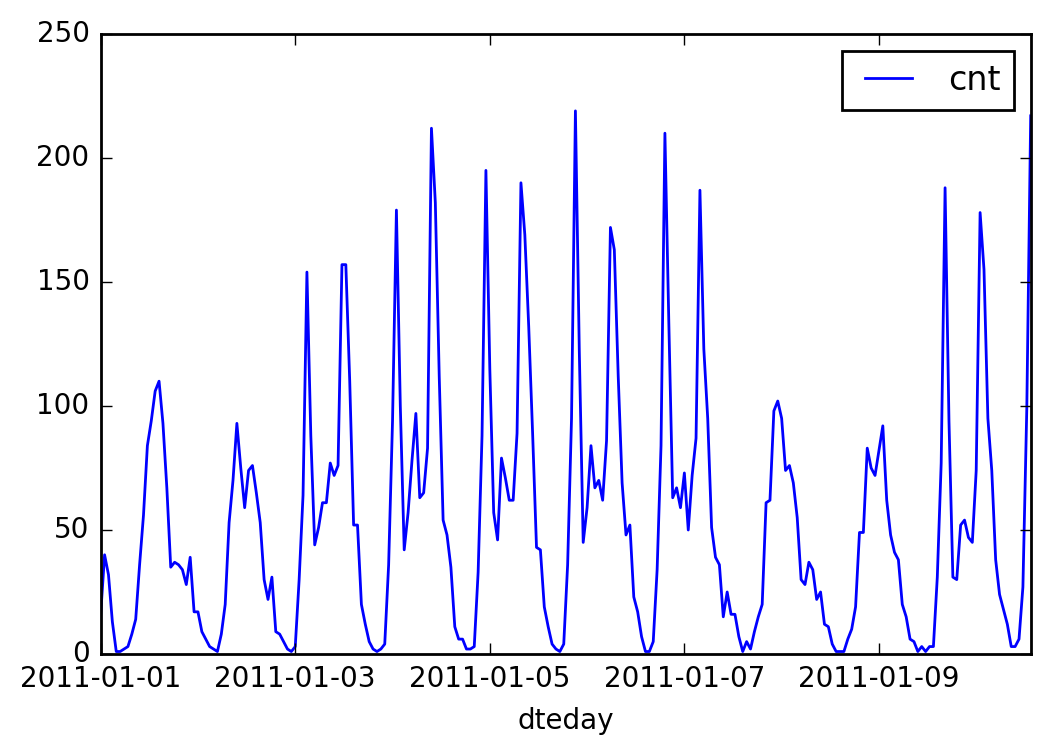

In [4]:
rides.head(24*10).plot(x='dteday',y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [6]:
categorical_variables=['season','mnth','weathersit','hr', 'weekday']
for each in categorical_variables:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()  

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0.22,0.80,0.0,8,32,40,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0.22,0.80,0.0,5,27,32,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0.24,0.75,0.0,3,10,13,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,0.24,0.75,0.0,0,1,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [121]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
data[quant_features]= scaler.fit_transform(data[quant_features],1)
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]

# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 10% to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [122]:
from sklearn.cross_validation import train_test_split
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
train_features, val_features,train_targets, val_targets = train_test_split(features, targets, test_size=0.1, random_state=42)
val_features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
15766,1,0,0.015647,0.740037,-0.821484,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14385,1,0,1.573679,-0.711309,-0.821484,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10138,1,0,-0.399828,0.221699,0.519896,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
346,0,0,-1.023041,-1.074146,-0.699689,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3707,0,0,1.365942,-0.244805,-0.211691,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


 ## The network

<img src="data/4_layer_network.png">


The network has three layers, 2 hidden layers and an output layer. The outermost hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

 The derivative of the output activation function ($f(x) = x$) for the backpropagation  is equivalent to the equation $y = x$. which is equal to 1.

In [123]:
class NeuralNetwork(object):
    
    def __init__(self,input_nodes, hidden_layer_one_nodes,hidden_layer_two_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_layer_one_nodes = hidden_layer_one_nodes
        self.hidden_layer_two_nodes=hidden_layer_two_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden_layer_one = np.random.normal(0.0, self.hidden_layer_one_nodes**-0.5, 
                                       (self.hidden_layer_one_nodes, self.input_nodes))

        self.weights_hidden_layer_one_to_hidden_layer_two = np.random.normal(0.0, self.hidden_layer_two_nodes**-0.5, 
                                       (self.hidden_layer_two_nodes, self.hidden_layer_one_nodes))
            
        self.weights_hidden_layer_two_to_output=np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_layer_two_nodes))
            
        self.lr = learning_rate
        
       
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1 +np.exp(-x))# sigmoid calculation.
        
    def train(self,inputs,targets):
            # Convert inputs list to 2d array
            inputs = np.array(inputs, ndmin=2).T
            targets = np.array(targets, ndmin=2).T
            
            ### Forward pass ###
            ### hidden layer one ###
            hidden_layer_one_outputs=np.dot(self.weights_input_to_hidden_layer_one,inputs)
            hidden_layer_two_inputs=hidden_layer_one_outputs
            ### hidden layer 2 ###
            hidden_layer_two_outputs=np.dot(self.weights_hidden_layer_one_to_hidden_layer_two,hidden_layer_two_inputs)
            hidden_layer_two_outputs= self.activation_function(hidden_layer_two_outputs)
            ## OutPut layer
            final_layer_inputs= np.dot(self.weights_hidden_layer_two_to_output,hidden_layer_two_outputs)
            final_outputs=final_layer_inputs
            
            
            #  Output error
            output_errors = targets-final_outputs # Output layer error is the difference between desired target and actual output.
        
            ### Back Propagation ###
            ## since the derivative of the output layer function is one the weights at the output layer are adjusted as follows
        
            self.weights_hidden_layer_two_to_output += self.lr *output_errors* hidden_layer_two_outputs.T
            
            ### for the last hidden layer the derivative of the sigmoid is x(1-x)
           
            hidden_errors= output_errors*self.weights_hidden_layer_two_to_output
            hidden_gradient= hidden_layer_two_outputs*(1-hidden_layer_two_outputs)
            
            self.weights_hidden_layer_one_to_hidden_layer_two +=self.lr*np.dot(hidden_gradient*hidden_errors.T,hidden_layer_two_inputs.T)
            
            ## For the first hidden layer  the backpropagated error is 
            hidden_errors_at_layer_1=np.dot(hidden_errors, self.weights_hidden_layer_one_to_hidden_layer_two)
            
            self.weights_input_to_hidden_layer_one +=self.lr* np.dot(hidden_gradient* hidden_errors_at_layer_1.T,inputs.T)
            
            
    def run_forward_pass(self,inputs):
            # Convert inputs list to 2d array
            inputs = np.array(inputs, ndmin=2).T
       
            # run a foward propagation through the networks
            ### hidden layer one ###
            hidden_layer_one_outputs=np.dot(self.weights_input_to_hidden_layer_one,inputs)
            hidden_layer_two_inputs=hidden_layer_one_outputs
            ### hidden layer 2 ###
            hidden_layer_two_outputs=np.dot(self.weights_hidden_layer_one_to_hidden_layer_two,hidden_layer_two_inputs)
            hidden_layer_two_outputs= self.activation_function(hidden_layer_two_outputs)
            ## OutPut layer
            final_layer_inputs= np.dot(self.weights_hidden_layer_two_to_output,hidden_layer_two_outputs)
            final_outputs=final_layer_inputs
            return final_outputs
            
            
        

In [124]:
##Mean squared error function
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [135]:
import sys

### Set the hyperparameters here ###
epochs = 10000
learning_rate = 0.01
hidden_nodes = 30
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, hidden_nodes,output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run_forward_pass(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run_forward_pass(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.056 ... Validation loss: 0.059

(0.0, 0.5)

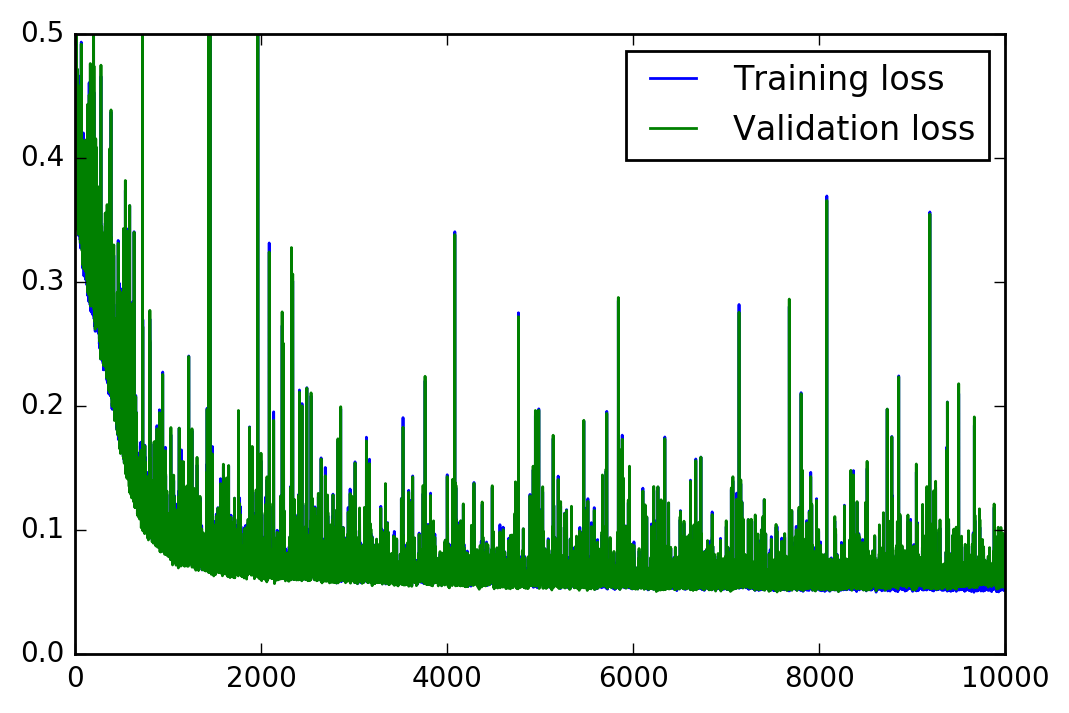

In [136]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

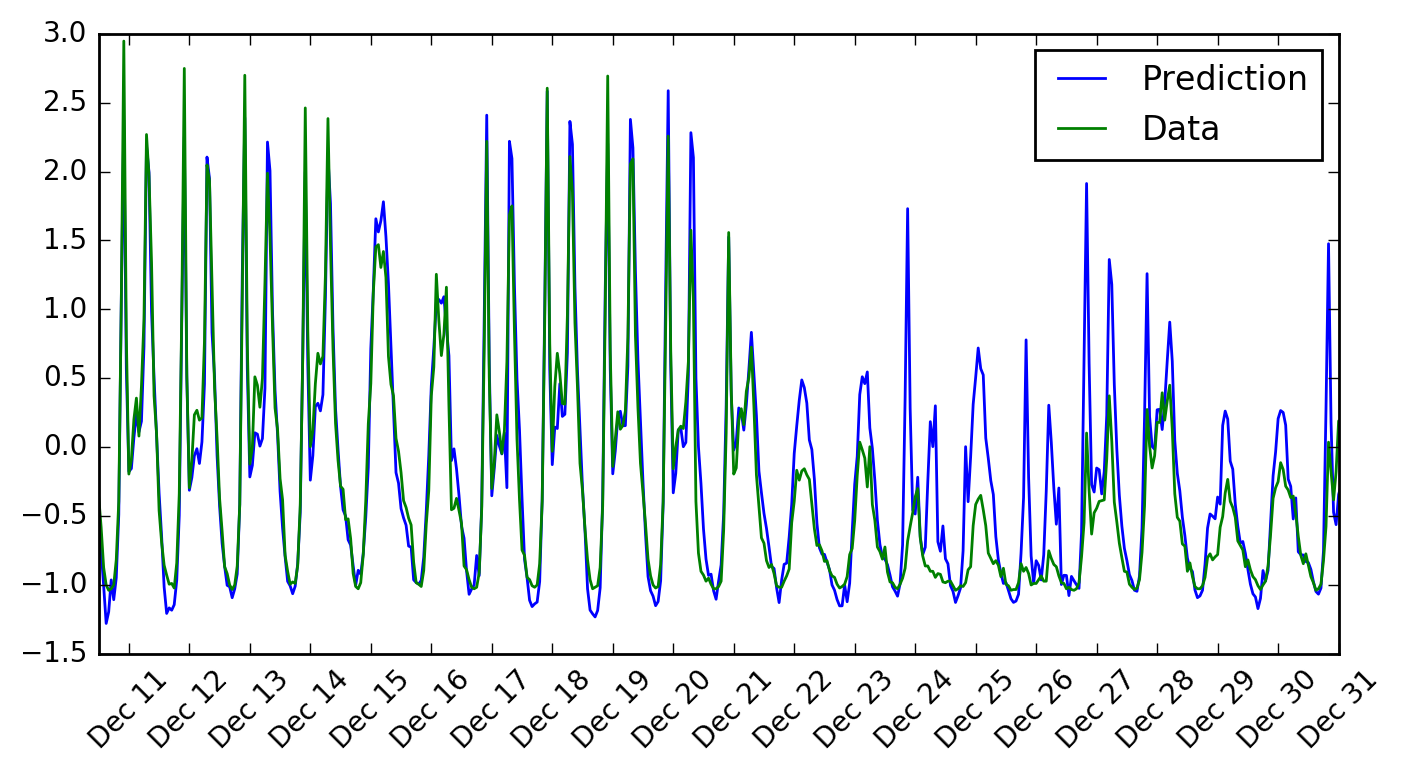

In [137]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run_forward_pass(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)